# Path integral Monte Carlo
The programme implements the path integral Monte Carlo procedure to diagonalize the anharmonic oscillator, whose path integral is given by:

$$
\left<x_f\left|\ e^{-iHt}\ \right|x_i\right>\ =\int_{x(0)=x_i}^{x(t)=x_f} \mathcal{D}x\ e^{iS[x]}\qquad\qquad
S[x]=\int_0^t dt\left[\frac{1}{4}\dot{x}^2-\left(x^2-\eta^2\right)^2\right]
$$

Correlations functions and their logarithmic derivatives are computed both in standard and cooled configurations.

Input parameters, with default values:
- potential parameters: $\lambda=1$, $\eta=1.4$
- mass of the particle: $m=0.5$
- number of lattice points: $N=800$
- lattice spacing: $a=0.05$
- number of Metropolis configurations: $N_{sweeps}=100$
- number of sweeps between each measurement: $N_{cor}=100$
- number of Metropolis sweeps in sample path: $N_{path}=2000$
- number of cooling sweeps: $N_{cool}=200$

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from numpy import diff
import math
import random
from tqdm.notebook import tqdm

In [2]:
# Parameters of the potential
Lambda = float(input("lambda = ") or 1)
eta = float(input("eta = ") or 1.4)
m = float(input("m = ") or 1/2)
hbar = 1;

lambda = 
eta = 
m = 


In [3]:
# Lattice parameters
N = int(input("N = ") or 800)
a = float(input("a = ") or 0.05)
Nsweeps = int(input("Nsweeps = ") or 100)
Ncor = int(input("Ncorrelation = ") or 100)

N = 
a = 
Nsweeps = 
Ncorrelation = 


## Exact diagonalization
We repeat here the exact diagonalization procedure, which will be used for comparison in the following.

In [5]:
Ngrid = N
xmin = -5
xmax = 5
xvec = np.linspace(xmin, xmax, Ngrid)

# Initialization of the parameters
H = np.zeros((Ngrid, Ngrid))               # Hamiltonian matrix

w0 = 4*eta                                 # Frequency of the harmonic oscillator
B = -2*eta**2 - w0**2/4
C = eta**4
c = 1/(np.sqrt(w0))

# Build up H matrix for the anharmonic oscillator 
for n in range(Ngrid): 
    H[n, n] = 3*c**4*((n+1)**2+n**2) + B*c**2*(2*n+1) + w0*(n+0.5) + C                         # Matrix element <n|H|n>
    
for n in range(Ngrid-2):
    H[n, n+2] = H[n+2, n]= c**4*(4*n+6)*np.sqrt((n+1)*(n+2)) + B*c**2*np.sqrt((n+1)*(n+2))     # Matrix element <n|H|n+2>
    
for n in range(Ngrid-4):
    H[n, n+4] = H[n+4, n] = c**4*np.sqrt((n+1)*(n+2)*(n+3)*(n+4))                              # Matrix element <n|H|n+4>
    
w, v = LA.eig(H)              # Diagonalizing the H matrix

sortinds = np.argsort(w)      # Returns the indices that would sort the array w
EigVals = w[sortinds]         # Eigenvalues sorting
EigVecs = v[:,sortinds]       # Corresponding eigenvectors sorting

## Monte Carlo method

### Evaluating the action
The action in euclidean time $\beta=it$ is given by:

$$
S_E[x]=\int_0^\beta d\tau \left[\frac{1}{4}\dot{x}^2+\left(x^2-\eta^2\right)^2\right]
$$

We discretize the euclidean time coordinate as: $\tau_j=ja$, with $j=1,\dots,N$, so that the action becomes:

$$
S=\sum_{j=1}^N \left[\frac{1}{4a}\left(x_j-x_{j-1}\right)^2+a\left(x_j^2-\eta^2\right)^2\right]
$$

where $x_j\equiv x(\tau_j)$. Since only few terms of the action change when $x_j$ is updated in the Metropolis algorithm, the following function computes only these terms, as $\Delta S = S'-S = S'_j-S_j$ when $x_j$ is changed, where we denote by $S_j$ the action with only $x_j$-dependent terms, and the prime means updated:

$$
S_j=\frac{1}{4a}\left[\left(x_j-x_{j-1}\right)^2+\left(x_{j+1}-x_j\right)^2\right]+a\left(x_j^2-\eta^2\right)^2
$$

In [6]:
# Function that evaluates the action of a given configuration considering only j-dependent terms
def S(j, x):
    if j == N-1
        Action = ((x[j]-x[j-1])**2 + (x[0]-x[j])**2)/(4*a) + a*(x[j]**2-eta**2)**2       # Periodic boundary conditions
    else:
        Action = ((x[j]-x[j-1])**2 + (x[j+1]-x[j])**2)/(4*a) + a*(x[j]**2-eta**2)**2
    return Action

### Initial configuration
We can choose wether to start with a cold configuration $\{x_i\}^{(0)}=\{0\}$ or with a hot one $\{x_i\}^{(0)}=\{r_i\}$, where $r_i$ is a random variable.

In [7]:
# Generating the initial configuration
x = np.zeros(N)

while True:
    choice = input("Type C for cold start, H for hot start: ")
    if choice == "C":                          # Cold start configuration
        break
    elif choice == "H":
        for i in range(N):
            x[i] = x[i] + random.random()      # Hot start configuration
        break

Type C for cold start, H for hot start: C


### Metropolis algorithm
The Metropolis method generates an ensemble of configurations $\{x_i\}^{(k)}$, where $i=1,\dots,N$ labels the lattice points and $k=1,\dots,N_{sweeps}$ the various configurations. The configurations are generated via a trial update $x_i^{(k+1)}=x_i^{(k)}+\delta x$ performed for every lattice site, where $\delta x$ is for instance a Gaussian random number with the width of the distribution $\varepsilon$ adjusted such that the average acceptance rate for the trial updates is around $50\%$. The trial update is accepted with probability:

$$
P\left(x_i^{(k)}\rightarrow x_i^{(k+1)}\right)=\mbox{min}\left\{e^{-\Delta S}, 1\right\}
$$

A similar algorithm can be used to find the nearest classical solution to a given quantum one (the so called $\textit{instanton solution}$), by accepting only the updates that lower the action, $\Delta S<0$.

In [8]:
eps = float(input("epsilon = ") or 0.1)

# Function that updates x according to Metropolis algorithm
def update(y):
    for j in range(N):
        old_y = y[j]                                    # Save the original values
        old_Sj = S(j,y)
        y[j] = y[j] + random.gauss(0, eps)              # Update x[j]
        dS = S(j,y) - old_Sj                            # Change in action
        if np.exp(-dS) < random.random():               # Metropolis acceptance criterium
            y[j] = old_y                                # Restore the old value in case the condition is not satisfied
            
# Function that updates x cooling the system
def cooling(y):
    for j in range(N):
        old_y = y[j]                                    # Save the original values
        old_Sj = S(j,y)
        y[j] = y[j] + random.gauss(0, eps)              # Update x[j]
        dS = S(j,y) - old_Sj                            # Change in action
        if dS > 0:                                      # Cooling condition
            y[j] = old_y                                # Restore the old value in case the condition is not satisfied

epsilon = 


#### Sample path
The following code returns an example of euclidean path, obtained after $N_{path}=2000$ thermalization sweeps; the path is then cooled through $N_{cool}=500$ thermalization sweeps.

Npath = 
Ncool = 


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

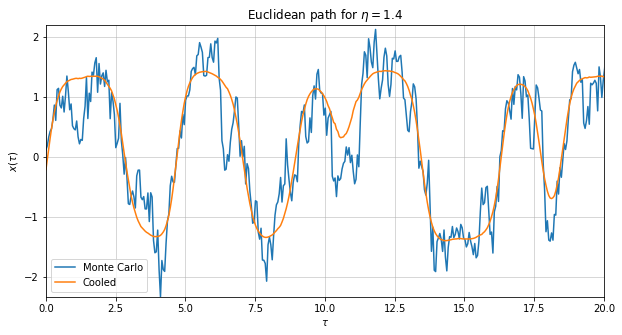

In [9]:
Npath = int(input("Npath = ") or 2000)
Ncool = int(input("Ncool = ") or 500)

def Path(y):
    for j in tqdm(range(Npath), leave = False):           # Updating the path through Npath steps
        update(y)
    return y

x = Path(x);
tau_vec = np.linspace(0, N*a, N)           # Total euclidean time obtained from lattice spacing a and from N

# Plotting the euclidean path
fig, ax = plt.subplots(figsize =( 10,5))
ax.plot(tau_vec, x, label = 'Monte Carlo')
ax.set_xlabel('$\\tau$')
ax.set_ylabel('$x(\\tau)$')
plt.xlim([0, 20])
plt.ylim([min(x), max(x)])
plt.grid(linewidth = 0.5)
plt.title('Euclidean path for $\eta =$' + str(eta));

def CooledPath(y):
    for k in tqdm(range(Ncool), leave = False):           # Cooling the path through Ncool steps
        cooling(y)
    return y

x_cooled = CooledPath(x)

# Plotting the cooled path
ax.plot(tau_vec, x_cooled, '-', label = 'Cooled')
plt.legend()
plt.show()

We see that for small $\tau$ the system is controlled by the oscillation time $\tau_{osc}$, while for large $\tau$ it is governed by the tunneling time $\tau_{tun}$. We can estimate:

$$
\tau_{osc}\sim \frac{1}{4\eta}\qquad\mbox{and}\qquad \tau_{tun}\sim \mbox{exp}\left(-\frac{4}{3}\eta^3\right)
$$

and in order to have a reliable simulation we should check that the lattice spacing is small compared to $\tau_{osc}$ and the total length of the lattice $Na$ is much larger than the tunneling time:
$$
a\ll \tau_{osc}\qquad\mbox{and}\qquad \tau_{tun}\ll Na
$$
In our case we have:

In [10]:
print("a = " + str(a) + "           tau_osc = " + str(round(1/(4*eta), 3)))
print("tau_tun = " + str(round(math.exp(-4*eta**3/3), 3)) + "    N*a = " + str(N*a))

a = 0.05           tau_osc = 0.179
tau_tun = 0.026    N*a = 40.0


### Correlation functions
The two point correlation function of order $t$ is defined as follows:

$$
G_t^{(2)}(x, \Delta\tau)\equiv \langle [x(\tau)]^t [x(\tau+\Delta\tau)]^t\rangle \approx \frac{1}{N}\sum_{i=1}^N \sum_{j\in J}x_i^t x_j^t
$$

where $J=\left\{j: 0\leq j\leq N, j-i=\Delta\tau\ \mbox{mod } N\right\}$ and $x_i = x(\tau_i)$, $\tau_i = i\Delta\tau$. In the following we will consider $t=1, 2, \dots, N_{cf}$ with $N_{cf}=3$ by default. Quantum mechanical averages are computed by averaging observables over many configurations:

$$
\langle\mathcal{O}\rangle = \lim_{N_{config}\to \infty}\frac{1}{N_{config}}\sum_{k=1}^{N_{config}}\mathcal{O}^{(k)}
$$

The method allows to estimate the error in the measurement of $\left<\mathcal{O}\right>$ from statistical fluctuations, under the assumption that the different configurations are statistically independent (which is to be verified by computing the auto-correlation time in successive measurements, and can be tuned by $N_{cor}$):

$$
\Delta\left<\mathcal{O}\right>=\sqrt{\frac{\left<\mathcal{O}^2\right>-\left<\mathcal{O}\right>^2}{N_{sweeps}}}
$$

We will therefore need to compute the mean value $\left<\mathcal{O}\right>$ as well, and therefore to consider one-point correlation functions:

$$
G_t^{(1)}(x)\equiv \langle [x(\tau)]^t \rangle \approx \frac{1}{N}\sum_{i=1}^N x_i^t
$$

In [11]:
Ncf = int(input("N of correlation functions = ") or 3)

# Function that computes the two-point correlation function of order t
def computeG2(x, dtau, t):
    g = 0                                      # Initialize the value of the correlation function
    for j in range(N):
        g = g + (x[j]**t)*(x[(j+dtau)%N]**t)   # Add all the terms satisfying the above condition for J
    return g/N

# Function that computes the Monte Carlo average
def MCaverage(x):
    G = np.zeros((Nsweeps, N, Ncf))            # Initialize the value of the two-point correlation function
    G1 = np.zeros((Nsweeps, N, Ncf))           # Initialize the value of the one-point correlation function
    
    for j in range(5*Ncor):                    # Initial thermalization
        update(x)
    for k in tqdm(range(Nsweeps), leave = False):
        for j in range(Ncor):                  # Thermalization steps between each measurement
            update(x)
        for t in range(Ncf):                   # Evaluate correlation functions of order t = 1, 2, ..., Ncf
            for n in range(N):
                G[k, n, t] = computeG2(x, n, t+1)
                G1[k, n, t] = x[n]**t/N

    avg_G = np.zeros((N, Ncf))                 # Initialize the value of the average
    avg_G1 = avg_G                             # (both for one- and two-point correlation functions)
    
    for n in range(N):                         # Compute the Monte Carlo average for each order t
        for t in range(Ncf):
            for k in range(Nsweeps):
                avg_G[n, t] = avg_G[n, t] + G[k, n, t]          # Two-point correlation function
                avg_G1[n, t] = avg_G1[n, t] + G1[k, n, t]       # One-point correlation function
    avg_G = avg_G / Nsweeps
    avg_G1 = avg_G1 / Nsweeps
        
    return avg_G, avg_G1


# Computing the first Ncf correlation functions
G_two, G_one = MCaverage(x)

deltaG = np.sqrt(np.abs(G_two - np.power(G_one, 2)) / Nsweeps)           # Statistical error

x_hist = x                          # x-value which will be needed in plotting the histogram

N of correlation functions = 


  0%|          | 0/100 [00:00<?, ?it/s]

#### Comparison with exact diagonalization
The correlation functions can be also computed using exact diagonalization, in order to see wether the two different methods give the same result. Letting $O(\tau)=x(\tau)^t$, we have that the two-point correlation functions $G_t^{(2)}(x,\tau)=\left<O(0)O(\tau)\right>$ can be computed by inserting a complete set of states in the expectation value:

$$
G_t^{(2)}(x,\tau)=\sum_{n}\left|\left<0|O(0)|n\right>\right|^2\ e^{-(E_n-E_0)\tau}
$$

The brakets $\left<0|O(0)|n\right>$ can be then evaluated analytically:

$$
\left<0|x(0)|n\right> = \frac{1}{2m\omega} c_n^2\qquad\qquad
\left<0|x^2(0)|n\right> = \frac{1}{(2m\omega)^2} d_n^2\qquad\qquad
\left<0|x^3(0)|n\right> = \frac{1}{(2m\omega)^3} e_n^2
$$
with:
$$
\begin{gather}
c_n = \left[\sum_{k=0}^N v_{0}(k)\sqrt{k} + v_0(k)\sqrt{k+1} \right]v_n(k)\\
d_n = \left[\sum_{k=0}^N v_{0}(k)\sqrt{k(k-1)} + (2k+1)v_0(k) + v_0(k)\sqrt{(k+1)(k+2)}\right]v_n(k)\\
e_n = \left[\sum_{k=0}^N v_{0}(k)\sqrt{k(k-1)(k-2)} + 3kv_0(k)\sqrt{k} + 3(k+1)v_0(k)\sqrt{k+1} + v_0(k)\sqrt{(k+1)(k+2)(k+3)}\right]v_n(k)
\end{gather}
$$

where $v_n(k)$ is the $n$-th eigenvector component of index $k$. In the following code, conditions on the $k$ index are included, so that the quantities does not become ill-defined for certain values of $k$.

In [90]:
# Function that evaluates the braket in the above expression for G
def Compute_xvalues(v):
    w = 4*eta;                       # Frequency of the corresponding harmonic oscillator
    rho = np.zeros((N, 3))           # Initialize the density of states
    
    for n in tqdm(range(N), leave = False):         # Loop over all lattice points
        cn = 0
        dn = 0
        en = 0
        
        for k in range(N):           # Loop over all eigenvalues
            km3 = max(k-3, 0)        # Conditions to ensure that the square roots exist
            km2 = max(k-2, 0)
            km1 = max(k-1, 0)
            kp1 = min(k+1, N-1)
            kp2 = min(k+2, N-1)
            kp3 = min(k+3, N-1)
            
            # Expressions coming from analytic computation of the braket
            cn = cn + ( np.sqrt(k)*v[km1, 0] + np.sqrt(k+1)*v[kp1, 0] )*v[k, n]
            dn = dn + ( np.sqrt(k*(k-1))*v[km2, 0] + (2*k+1)*v[k, 0] + np.sqrt((k+1)*(k+2))*v[kp2, 0] )*v[k, n]
            en = en + ( np.sqrt(k*(k-1)*(k-2))*v[km3, 0] + 3*k*np.sqrt(k)*v[km1, 0] + 3*(k+1)*np.sqrt(k+1)*v[kp1, 0] \
                    + np.sqrt((k+1)*(k+2)*(k+3))*v[kp3, 0] )*v[k, n]
            
        rho[n, 0] = 1/(m*w)/2*cn**2
        rho[n, 1] = 1/(m*w)**2/4*dn**2
        rho[n, 2] = 1/(m*w)**3/8*en**2
        
    return rho
            

# Function that evaluates the two-point correlation function from exact diagonalization
G_exact = np.zeros((N, 3))             # Here Ncf = 3 for simplicity
rho = Compute_xvalues(EigVecs)
    
for n in range(N):
    for k in range(50):                # 50 eigenvalues are enough
        for j in range(3):
            G_exact[n, j] = G_exact[n, j] + rho[k, j] * np.exp(-(EigVals[k]-EigVals[0])*tau_vec[n])     

  0%|          | 0/800 [00:00<?, ?it/s]

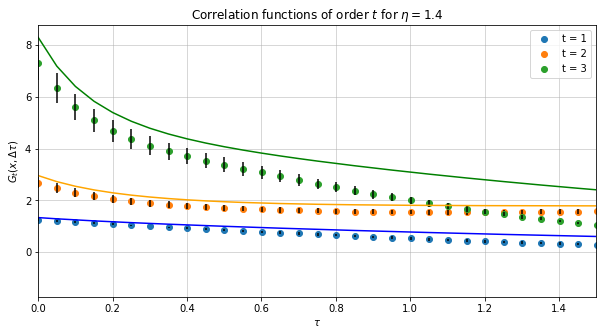

In [87]:
# Plotting the correlation functions
fig, ax = plt.subplots(figsize = (10,5))

for i in range(Ncf):
    ax.plot(tau_vec, G_two[:,i], 'o', label = 't = '+str(i+1))
    plt.errorbar(tau_vec, G_two[:,i], yerr = deltaG[:,i], xerr = None, fmt = 'None', ecolor = 'black')
    
ax. plot(tau_vec, G_exact[:,0], color = 'blue')
ax. plot(tau_vec, G_exact[:,1], color = 'orange')
ax. plot(tau_vec, G_exact[:,2], color = 'green')

ax.set_xlabel('$\\tau$')
ax.set_ylabel('$G_t(x,\Delta\\tau)$')
plt.xlim([0, 1.5])
plt.grid(linewidth = 0.5)
plt.title('Correlation functions of order $t$ for $\eta =$'+str(eta));
plt.legend()
plt.show()

#### Probability distribution
The ground state wavefunction coming from exact diagonalization can be compared with the probability distribution of $x$ in Monte Carlo simulations.

In [18]:
# Function that computes the Hermite polynomials p(i = 0,...,n) = H_i(x)
def hermite3(n, x, p):            # Rescaled Hermite polynomials H_i(x) / (2^i*sqrt(i!))
    p = np.zeros(n+1)
    p[0] = 1
    p[1] = x
    
    for i in range (2, n+1):
        p[i] = (x*p[i-1] - np.sqrt(i-1)*p[i-2]/2) / np.sqrt(float(i))

    return p

# Harmonic oscillator wave function psi(i = 0,..,n) = psi_i(x)
def psiosc(n, x, psi):
    psi = np.zeros(n+1)           # Wave function
    h = np.zeros(n+1)             # Hermite polynomials 
    
    y = np.sqrt(w0/2)*x
    h = hermite3(n, y, h)
    
    for i in range(n+1):
        xnorm = (w0/(2*np.pi))**0.25*2**(i/2)
        psi[i] = xnorm*h[i]*np.exp(-m*w0/2*x**2)
        
    return psi

# Ground state wavefunction psix
psi = np.zeros(Ngrid)        # Harmonic oscillator wave function
psix = np.zeros(Ngrid)       # Anharmonic oscillator wave function

for k in tqdm(range(Ngrid), leave = False):
    psi = psiosc(Ngrid-1, xvec[k], psi)

    for j in range(Ngrid-1):
        psix[k] = psix[k] + EigVecs[j,0]*psi[j]

  0%|          | 0/800 [00:00<?, ?it/s]

Since $|\psi(x)|^2$ gives the probability for $x$ of having a given value, to compare it with the histogram of counts in Monte Carlo simulations we have to multiply it by the total number of points, that is, $N$.

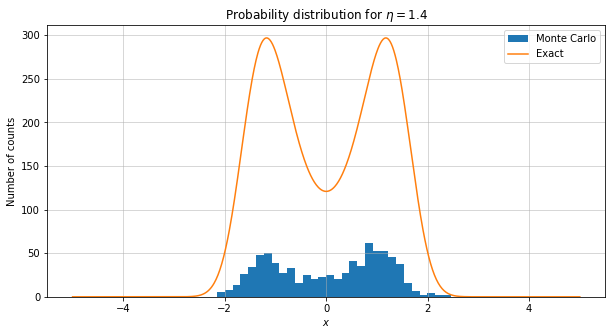

In [22]:
psi_squared = np.power(np.abs(psix), 2)             # Computing the square modulus of the wavefunction
norm = np.trapz(psi_squared, xvec)
counts = N*psi_squared/norm

fig, ax = plt.subplots(figsize = (10,5))
ax.hist(x_hist, 30, label = 'Monte Carlo')
ax.plot(xvec, counts, label = 'Exact')              # Exact result from diagonalization, for comparison
ax.set_xlabel('$x$')
ax.set_ylabel('Number of counts')
plt.grid(linewidth = 0.5)
plt.title('Probability distribution for $\eta =$' + str(eta));
plt.legend()
plt.show()

#### Logarithmic derivative of the correlation function
The energy levels can be obtained from the logarithmic derivative of the correlation function,

$$
C_t(\tau)=-\frac{d}{d\tau}\log{G_t^{(2)}}(\tau) = \frac{\sum_n (E_n-E_0)|\left<0|O(0)|n\right>|^2 e^{-(E_n-E_0)\tau}}{\sum_n |\left<0|O(0)|n\right>|^2 e^{-(E_n-E_0)\tau}}
$$

which in the limit $\tau\to \infty$ converges to the energy splitting between the ground state and the first excited state that has a non-zero transition amplitude equal to $\left<0|O(0)|n\right>$. The even order correlations functions are subtracted by a constant term:

$$
G^{(2)}_{2n,\ sub}(x, \Delta\tau) = G^{(2)}_{2n}(x, \Delta\tau) - \left|\left<0|x^{2n}|0\right>\right|^2
$$

and the error associated to the constant term is computed from the one of $G^{(2)}_{2n}$ using the fact that $\Delta G^{(1)}_{2n}(x) = \Delta G^{(2)}_{2n}(x,N)$. We then sum the errors as follows:

$$
\Delta G^{(2)}_{2n,\ sub}(x, \Delta\tau) = \sqrt{\left[\Delta G^{(2)}_{2n}(x, \Delta\tau)\right]^2 + \left[2G^{(1)}_{2n}(x)\ \Delta G^{(1)}_{2n}(x)\right]^2}
$$

For all values of $t$ (using $G^{(2)}_{t,\ sub}$ instead of $G^{(2)}_{t}$ for $t$ even) the errors associated to the discretized logarithmic derivative are computed as follows:

$$
\Delta_{Logder} = \sqrt{\left[\frac{\Delta G^{(2)}_{t}(x_{j+1})}{G^{(2)}_{t}(x_j)}\right]^2 + \left[\frac{\Delta G^{(2)}_{t}(x_{j})\ G^{(2)}_{t}(x_{j+1})}{G^{(2)}_{t}(x_j)}\right]^2}
$$

C:\Users\Fabio\AppData\Local\Temp\ipykernel_17024\1789193940.py:8: RuntimeWarning: divide by zero encountered in log
  logx = np.log(x)


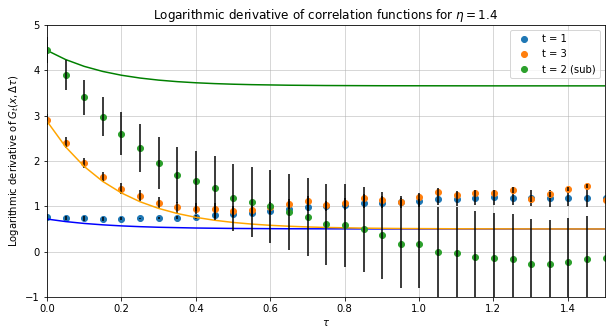

In [91]:
# Function that computes the logarithmic derivative of a vector
def logder(x):
    
    for i in range(len(x)):
        if x[i] <= 0:
            x[i] = 1e-10
    
    logx = np.log(x)
    logder = - diff(logx) / a
    logder = np.append(logder, 0)
    
    return logder

# Plotting the logarithmic derivative of the correlation functions
fig, ax = plt.subplots(figsize = (10,5))

for i in range(0, Ncf, 2):
    ax.plot(tau_vec, logder(np.abs(G_two[:,i])), 'o', label = 't = ' + str(i+1))
    
    logG_err = np.zeros((N,3))
    for j in range(N-1):
        logG_err[j,i] = np.square(deltaG[j+1,i] / G_two[j,i]) + np.square(deltaG[j,i]*G_two[j+1,i] / np.square(G_two[j,i]))
        logG_err[j,i] = np.sqrt(logG_err[j,i])

    plt.errorbar(tau_vec, logder(np.abs(G_two[:,i])), yerr = logG_err[:,i], xerr = None, fmt = 'None', ecolor = 'black')
    
# Subtraction term
G_exact_sub[:,1] = G_exact[:,1] - rho[0,1]

ax. plot(tau_vec, logder(np.abs(G_exact[:,0])), color = 'blue')
ax. plot(tau_vec, logder(np.abs(G_exact[:,1])), color = 'green')
ax. plot(tau_vec, logder(np.abs(G_exact[:,2])), color = 'orange')


# Even-order correlation function with constant value subtracted
Gsub = G_two[:,1] - np.square(G_one[:,1])
Gsub_err = np.sqrt(np.square(deltaG[:,1]) + np.square(2*G_one[:,1]*deltaG[N-1,1]))     # Error propagation

# Computing the errors of the logarithmic derivative
logG_err = np.zeros(N)
for j in range(N-1):
    logG_err[j] = np.square(Gsub_err[j+1] / Gsub[j]) + np.square(Gsub_err[j]*Gsub[j+1] / np.square(Gsub[j]))
    logG_err[j] = np.sqrt(logG_err[j])

# Plotting the subtracted correlation function
ax.plot(tau_vec, logder(np.abs(Gsub)), 'o', label = 't = 2 (sub)')
plt.errorbar(tau_vec, logder(np.abs(Gsub)), logG_err, xerr = None, fmt = 'None', ecolor = 'black')

ax.set_xlabel('$\\tau$')
ax.set_ylabel('Logarithmic derivative of $G_t(x,\Delta\\tau)$')
plt.xlim([0, 1.5])
plt.ylim([-1, 5])
plt.grid(linewidth = 0.5)
plt.title('Logarithmic derivative of correlation functions for $\eta =$' + str(eta));
plt.legend()
plt.show()

## Cooled Monte Carlo
We can repeat the same computations above, starting now from cooled configurations, in order to see what are the differences among the two cases.

In [58]:
# Function that computes the Monte Carlo average
def MCaverage_cooled(x):
    G = np.zeros((Nsweeps, N, Ncf))            # Initialize the value of the two-point correlation function
    G1 = np.zeros((Nsweeps, N, Ncf))           # Initialize the value of the one-point correlation function
    
    for j in range(5*Ncor):                    # Initial thermalization
        update(x)
    for k in tqdm(range(Nsweeps), leave = False):
        for j in range(Ncor):                  # Thermalization steps between each measurement
            update(x)
        for j in range(Ncool):                 # Cooling steps before measurement
            cooling(x)
        for t in range(Ncf):                   # Evaluate correlation functions of order t = 1, 2, ..., Ncf
            for n in range(N):
                G[k, n, t] = computeG2(x, n, t+1)
                G1[k, n, t] = x[n]**t

    avg_G = np.zeros((N, Ncf))                 # Initialize the value of the average
    avg_G1 = avg_G                             # (both for one- and two-point correlation functions)
    
    for n in range(N):                         # Compute the Monte Carlo average for each order t
        for t in range(Ncf):
            for k in range(Nsweeps):
                avg_G[n, t] = avg_G[n, t] + G[k, n, t]           # Two-point correlation function
                avg_G1[n, t] = avg_G1[n, t] + G1[k, n, t]        # One-point correlation function
    avg_G = avg_G / Nsweeps
    avg_G1 = avg_G1 / Nsweeps
        
    return [avg_G, avg_G1]


# Computing the first Ncf correlation functions
[G_twoC, G_oneC] = MCaverage_cooled(x)

deltaGC = np.sqrt(np.abs(G_twoC - np.power(G_oneC, 2)) / Nsweeps)          # Statistical error

  0%|          | 0/100 [00:00<?, ?it/s]

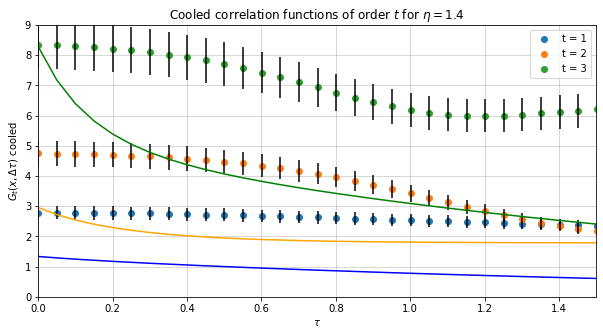

In [61]:
# Plotting the correlation functions
fig, ax = plt.subplots(figsize = (10,5))

for i in range(Ncf):
    ax.plot(tau_vec, G_twoC[:,i], 'o', label = 't = '+str(i+1))
    plt.errorbar(tau_vec, G_twoC[:,i], yerr = deltaGC[:,i], xerr = None, fmt = 'None', ecolor = 'black')
    
ax. plot(tau_vec, G_exact[:,0], color = 'blue')
ax. plot(tau_vec, G_exact[:,1], color = 'orange')
ax. plot(tau_vec, G_exact[:,2], color = 'green')

ax.set_xlabel('$\\tau$')
ax.set_ylabel('$G_t(x,\Delta\\tau)$ cooled')
plt.xlim([0, 1.5])
plt.ylim([0, 9])
plt.grid(linewidth = 0.5)
plt.title('Cooled correlation functions of order $t$ for $\eta =$'+str(eta));
plt.legend()
plt.show()

### Logarithmic derivatives

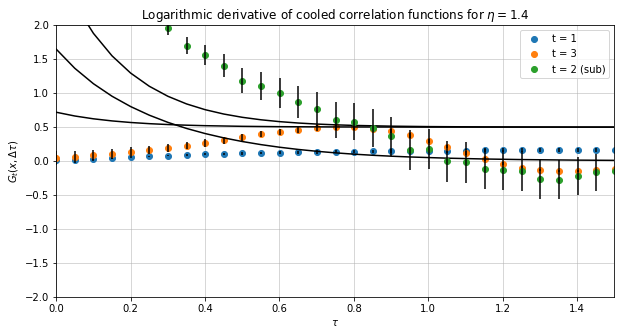

In [62]:
# Plotting the logarithmic derivative of the correlation functions
fig, ax = plt.subplots(figsize=(10,5))

for i in range(0, Ncf, 2):
    ax.plot(tau_vec, logder(np.abs(G_twoC[:,i])), 'o', label = 't = '+str(i+1))
    
    logG_err = np.zeros((N,3));
    for j in range(N-1):
        logG_err[j,i] = np.square(deltaG[j+1,i] / G_twoC[j,i]) + np.square(deltaG[j,i]*G_twoC[j+1,i] / np.square(G_twoC[j,i]));
        logG_err[j,i] = np.sqrt(logG_err[j,i]);

    plt.errorbar(tau_vec, logder(np.abs(G_twoC[:,i])), yerr = logG_err[:,i], xerr = None, fmt = 'None', ecolor = 'black')
    
for i in range(Ncf):    
    ax. plot(tau_vec, logder(np.abs(G_exact[:,i])), color = 'black')

# Even-order correlation function with constant value subtracted
Gsub = G_two[:,1] - np.power(G_one[:,1], 2);
Gsub_err = np.sqrt(np.square(deltaG[:,1]) + np.square(2*G_one[:,1]*deltaG[:,0]));   # Error propagation

# Computing the errors of the logarithmic derivative
logG_err = np.zeros(N);
for j in range(N-1):
    logG_err[j] = np.square(Gsub_err[j+1] / Gsub[j]) + np.square(Gsub_err[j]*Gsub[j+1] / np.square(Gsub[j]));
    logG_err[j] = np.sqrt(logG_err[j]);

ax.plot(tau_vec, logder(np.abs(Gsub)), 'o', label = 't = 2 (sub)')
plt.errorbar(tau_vec, logder(np.abs(Gsub)), logG_err, xerr = None, fmt = 'None', ecolor = 'black')

ax.set_xlabel('$\\tau$');
ax.set_ylabel('$G_t(x,\Delta\\tau)$');
plt.xlim([0, 1.5])
plt.ylim([-2, 2])
plt.grid(linewidth=0.5);
plt.title('Logarithmic derivative of cooled correlation functions for $\eta =$'+str(eta));
plt.legend()
plt.show()